In [1]:
!ls

quick_start_pytorch_images  refpred


In [2]:
# !conda install -c pytorch faiss-gpu

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.cm as cm

from transformers import AutoModel, AutoTokenizer
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KDTree, BallTree
from tqdm import tqdm

import pickle
import ast
import random

In [3]:
torch.cuda.is_available(), torch.cuda.current_device(), torch.cuda.get_device_name(0)

(True, 0, 'Quadro RTX 5000')

In [4]:
DATA_PATH = 'refpred/data'

In [5]:
with open(f'{DATA_PATH}/output_10k.json', 'r') as f:
    embeddings = [json.loads(line) for line in f]

In [6]:
with open(f'{DATA_PATH}/metadata_10k_full.json', 'r') as f:
    metadata = json.load(f)

In [7]:
# originally there were 10K papers, however removing papers with null title/abstract or 0 references resulted in 700 less
all_paper_ids = [e['paper_id'] for e in embeddings]
zero_ref_pids = [pid for pid in all_paper_ids if len(ast.literal_eval(metadata[pid]['references'])) == 0]
all_paper_ids = list(set(all_paper_ids) - set(zero_ref_pids))
all_pid_set = set(all_paper_ids)
len(all_paper_ids)

9319

In [8]:
# remove 0 reference pids
embeddings = [e for e in embeddings if e['paper_id'] in all_pid_set]

In [9]:
metadata = {k:v for k,v in metadata.items() if k in all_pid_set}

In [10]:
for pid in metadata:
    p = metadata[pid]
    p['references'] = ast.literal_eval(p['references'])

In [11]:
# # Maybe a list of all references needed if we are preparing reranking model data randomly and
# # need to compare years of the references to the query paper (to ensure the model does not have 
# # access to future information 


# for pid in metadata:
#     p = metadata[pid]
#     p['references'] = ast.literal_eval(p['references'])

# all_references = set()
# for pid in metadata:
#     p = metadata[pid]
#     p_refs = p['references']
#     all_references.update(p_refs)
# len(all_references)

In [12]:
weights = torch.stack([torch.tensor(e['embedding']) for e in embeddings]).double()
# all_paper_ids = [e['paper_id'] for e in embeddings]

In [13]:
len(weights)

9319

In [14]:
len(embeddings), len(metadata)

(9319, 9319)

In [15]:
metadata['659408b243cec55de8d0a3bc51b81173007aa89b']['references']

KeyError: '659408b243cec55de8d0a3bc51b81173007aa89b'

In [16]:
embedding_map = {}
for obj in embeddings:
    # object is a dict like {'paper_id': str, 'embedding': np.array}
    paper_id, emb_768 = obj.values()
    arr = np.asarray(emb_768)
    embedding_map[paper_id] = torch.tensor(arr, dtype=torch.float32)

In [17]:
len(embedding_map)

9319

In [18]:
embedding_matrix = np.array([embedding_map[paper_id].numpy() for paper_id in all_paper_ids])

# We can use l2 distance ªas cosine distance isn't really a thing in sklearn BallTree/KDTree) so long as the input matrix is l2 normalized
# in this case it will result in the same ordering as a cosine distance
# https://stackoverflow.com/questions/34144632/using-cosine-distance-with-scikit-learn-kneighborsclassifier
knn_tree = BallTree(embedding_matrix, metric='l2')

In [19]:
reference_map = {}
# fetch references from metadata dict in the format {paper_id: [list of references]}
for paper_id in all_paper_ids:
    # references = ast.literal_eval(metadata[paper_id].get('references'))
    references = metadata[paper_id].get('references')
    reference_map[paper_id] = references or []

In [20]:
len(reference_map)

9319

In [21]:
train_paper_ids, test_paper_ids = train_test_split(all_paper_ids, test_size=0.2, random_state=42)
val_paper_ids, test_paper_ids = train_test_split(test_paper_ids, test_size=0.5, random_state=42)

In [22]:
len(train_paper_ids) +  len(val_paper_ids) + len(test_paper_ids)

9319

In [23]:
specter_tokenizer = AutoTokenizer.from_pretrained('allenai/specter')
specter_model = AutoModel.from_pretrained('allenai/specter')

In [24]:
@torch.no_grad()
def get_embedding(paper, embedding_map=None):
    '''
    Given an input paper (dict with at least 'title' as a key, returns a 768 dimensional embeddings using the SPECTER model from HF.
    '''
    assert type(paper)==dict and 'title' in paper.keys(), "paper must be a dict with at least 'title' as a key"
    if embedding_map and paper['paper_id'] is not None and paper['paper_id'] in embedding_map:
        return embedding_map[paper['paper_id']].view(1,-1)
    # tokenizer = AutoTokenizer.from_pretrained('allenai/specter')
    # model = AutoModel.from_pretrained('allenai/specter')
    title_abs = [d['title'] + specter_tokenizer.sep_token + (d.get('abstract') or '') for d in [paper]]
    inputs = specter_tokenizer(title_abs, padding=True, truncation=True, return_tensors="pt", max_length=512)
    result = specter_model(**inputs)
    cur_embedding = result.last_hidden_state[:, 0, :]
    return cur_embedding

In [25]:
def find_knn(cur_embedding, knn_tree, all_paper_ids, k=20, least = False):
    # current_embeddings shape: [1,768]
    # assert(torch.is_tensor(cur_embedding))
    # print(cur_embedding.shape)
    # assert(cur_embedding.shape==(1,768))
    scores, top_indices = knn_tree.query(cur_embedding.reshape(1,-1), k=k, return_distance=True)
    scores, top_indices = np.squeeze(scores), np.squeeze(top_indices)
    return top_indices, scores
    

In [26]:
def find_knn_pid(pid, knn_tree, embedding_map, metadata, all_paper_ids, k=20, least = False):
    paper_embedding = get_embedding(metadata[pid], embedding_map)
    top_indices, scores = find_knn(paper_embedding, knn_tree, all_paper_ids, k=20, least = False)
    recommended_paper_ids = [all_paper_ids[i] for i in top_indices]
    return recommended_paper_ids

In [103]:
## V1
# @torch.no_grad()
# def find_similar_knn(cur_embedding, embedding_map, k=10, least = False):
#     # current_embeddings shape: [1,768]
#     # weights shape: [num_of_egs, embedding_dim=768]
#     # cur_embedding = get_embedding(paper)
#     # input shape should be [1,768]
#     weights = 
#     assert(torch.is_tensor(cur_embedding))
#     # print(cur_embedding.shape)
#     assert(cur_embedding.shape==(1,768))
#     weights_norm = F.normalize(weights, p=2, dim=1).double() # (N, d)
#     cur_em_norm = F.normalize(cur_embedding, p=2, dim=1).double() # (1, d)
#     cos_sim = F.cosine_similarity(weights_norm, cur_em_norm, dim=1)
#     topk = torch.topk(cos_sim, k, largest = False if least else True)
#     top_indices = topk.indices
#     top_values = topk.values
#     return top_indices, top_values

## V2

# @torch.no_grad()
# def find_similar_knn(cur_embedding, weights, k=10, least = False):
#     # current_embeddings shape: [1,768]
#     # weights shape: [num_of_egs, embedding_dim=768]
#     # cur_embedding = get_embedding(paper)
#     # input shape should be [1,768]
#     assert(torch.is_tensor(cur_embedding))
#     # print(cur_embedding.shape)
#     assert(cur_embedding.shape==(1,768))
#     weights_norm = F.normalize(weights, p=2, dim=1).double() # (N, d)
#     cur_em_norm = F.normalize(cur_embedding, p=2, dim=1).double() # (1, d)
#     cos_sim = F.cosine_similarity(weights_norm, cur_em_norm, dim=1)
#     topk = torch.topk(cos_sim, k, largest = False if least else True)
#     top_indices = topk.indices
#     top_values = topk.values
#     return top_indices, top_values

In [27]:
def evaluate(recommended, actual, k=None):
    recommended = np.asarray(recommended)[:k] if k else np.asarray(recommended)
    actual = np.asarray(actual)
    
    if len(actual) == 0:
        print('No actual references stored in the metadata')
        return 0,0,0
    
    true_positives = np.intersect1d(recommended, actual)
    false_positives = np.setdiff1d(recommended, actual)
    false_negatives = np.setdiff1d(actual, recommended)
    
    assert(len(true_positives) + len(false_positives) == len(recommended))
    assert(len(true_positives) + len(false_negatives) == len(actual))

    precision = len(true_positives) / (len(true_positives) + len(false_positives))
    recall = len(true_positives) / (len(true_positives) + len(false_negatives))
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    
    return precision, recall, f1_score


In [149]:
# a3e4ceb42cbcd2c807d53aff90a8cb1f5ee3f031
new_title = 'SPECTER: Document-level Representation Learning using Citation-informed Transformers'

new_abstract = 'We propose SPECTER, a new method to generate document-level embedding of scientific documents based on pretraining a Transformer language model on a powerful signal of document-level relatedness: the citation graph. Unlike existing pretrained language models, SPECTER can be easily applied to downstream applications without task-specific fine-tuning. Additionally, to encourage further research on document-level models, we introduce SciDocs, a new evaluation benchmark consisting of seven document-level tasks ranging from citation prediction, to document classification and recommendation. We show that SPECTER outperforms a variety of competitive baselines on the benchmark.'

In [42]:
# 204e3073870fae3d05bcbc2f6a8e263d9b72e776
new_title = 'Attention Is All You Need'
new_abstract = 'The dominant sequence transduction models are based on complex recurrent or convolutional neural networks in an encoder-decoder configuration. The best performing models also connect the encoder and decoder through an attention mechanism. We propose a new simple network architecture, the Transformer, based solely on attention mechanisms, dispensing with recurrence and convolutions entirely. Experiments on two machine translation tasks show these models to be superior in quality while being more parallelizable and requiring significantly less time to train. Our model achieves 28.4 BLEU on the WMT 2014 English-to-German translation task, improving over the existing best results, including ensembles by over 2 BLEU. On the WMT 2014 English-to-French translation task, our model establishes a new single-model state-of-the-art BLEU score of 41.8 after training for 3.5 days on eight GPUs, a small fraction of the training costs of the best models from the literature. We show that the Transformer generalizes well to other tasks by applying it successfully to English constituency parsing both with large and limited training data.'

In [102]:
### MUCH MUCH FASTER ALGORITHM PRESENT BELOW
# # new_paper = {'title': new_title, 'abstract': new_abstract or ''}
# # assert new_paper['title'] is not None
# # paper_id = '204e3073870fae3d05bcbc2f6a8e263d9b72e776'
# k = 20
# test_paper_id = '204e3073870fae3d05bcbc2f6a8e263d9b72e776'
# paper_embedding = get_embedding(metadata[test_paper_id])
# top_indices, top_values = find_similar_knn(paper_embedding, weights, k=50, least=False)
# recommended_paper_ids = [all_paper_ids[i] for i in top_indices]


# cnt = 0
# for paper_id, cos_sim in zip(recommended_paper_ids, top_values):
#     title = metadata[paper_id]['title']
#     # abstract = metadata[paper_id]['abstract']
#     year = metadata[paper_id]['year']
#     print(f'Paper ID: {paper_id}\nTitle: {title}\nYear: {year}')# \nCosine similarity: {cos_sim}\n')
#     cnt += 1 
#     if cnt == 10:
#         break
        
# actual_references = ast.literal_eval(metadata[test_paper_id].get('references'))

# print('-'*100)

# precision, recall, f1_score = evaluate(recommended_paper_ids[1:], actual_references, k=k)
# print(f'For the Paper - {metadata[test_paper_id]["title"]}')
# print(f"Precision @ {k}: {precision}")
# print(f"Recall @ {k}: {recall}")
# print(f"F1 Score: {f1_score}")

In [29]:
# Cosine scores not available because BallTree doesn't have a cosine similarity metric however similar ranking is providied by normalized L2

k = 20
test_paper_id = '204e3073870fae3d05bcbc2f6a8e263d9b72e776'
# test_paper_id = '09ebd9ad4fa21c0d56433ac57a4cd69e94c72281'
# test_paper = metadata[test_paper_id]
# print(test_paper)
recommended_paper_ids = find_knn_pid(test_paper_id, knn_tree, embedding_map, metadata, all_paper_ids)


for i, pid in enumerate(recommended_paper_ids):
    title = metadata[pid]['title']
    # abstract = metadata[paper_id]['abstract']
    year = metadata[pid]['year']
    print(f'Paper ID: {pid}\nTitle: {title}\nYear: {year}')# \nCosine similarity: {cos_sim}\n')
    if i == 10:
        break

# NOT NEEDED as this is already done during metadata init
# actual_references = ast.literal_eval(metadata[test_paper_id].get('references'))
actual_references = metadata[test_paper_id].get('references')

print('-'*100)

precision, recall, f1_score = evaluate(recommended_paper_ids[1:], actual_references, k=k)
print(f'For the Paper - {metadata[test_paper_id]["title"]}')
print(f"Precision @ {k}: {precision}")
print(f"Recall @ {k}: {recall}")
print(f"F1 Score: {f1_score}")

Paper ID: 204e3073870fae3d05bcbc2f6a8e263d9b72e776
Title: Attention is All you Need
Year: 2017
Paper ID: 9ae0a24f0928cab1554a6ac880f6b350f85be698
Title: One Model To Learn Them All
Year: 2017
Paper ID: b60abe57bc195616063be10638c6437358c81d1e
Title: Deep Recurrent Models with Fast-Forward Connections for Neural Machine Translation
Year: 2016
Paper ID: dbde7dfa6cae81df8ac19ef500c42db96c3d1edd
Title: Google's Neural Machine Translation System: Bridging the Gap between Human and Machine Translation
Year: 2016
Paper ID: 43428880d75b3a14257c3ee9bda054e61eb869c0
Title: Convolutional Sequence to Sequence Learning
Year: 2017
Paper ID: 93499a7c7f699b6630a86fad964536f9423bb6d0
Title: Effective Approaches to Attention-based Neural Machine Translation
Year: 2015
Paper ID: 4550a4c714920ef57d19878e31c9ebae37b049b2
Title: Massive Exploration of Neural Machine Translation Architectures
Year: 2017
Paper ID: 2f2d8f8072e5cc9b296fad551f65f183bdbff7aa
Title: Exploring the Limits of Language Modeling
Year: 

In [30]:
def evaluate_knn(test_paper_ids, knn_tree, embedding_map, metadata, reference_map, all_paper_ids, k=20):
    precisions = []
    recalls = []
    for paper_id in tqdm(test_paper_ids):
        # paper_embedding = embedding_map[paper_id]
        # # Query the KD-tree to find k nearest neighbors
        # top_indices = knn_tree.query(paper_embedding.reshape(1,-1), k=k, return_distance=False)[0]
        # recommendations = set([all_paper_ids[i] for i in top_indices])
        recommendations = set(find_knn_pid(paper_id, knn_tree, embedding_map, metadata, all_paper_ids))
        true_references = set(reference_map.get(paper_id, []))
        if not true_references:
            continue
        intersect = recommendations.intersection(true_references)
        precision = len(intersect) / len(recommendations)
        recall = len(intersect) / len(true_references)
        precisions.append(precision)
        recalls.append(recall)
    mean_precision = sum(precisions) / len(precisions)
    mean_recall = sum(recalls) / len(recalls)
    return mean_precision, mean_recall

In [51]:
# def evaluate_knn(test_paper_ids, embedding_map, reference_map, k=20):
#     precisions = []
#     recalls = []
#     for paper_id in tqdm(test_paper_ids):
#         paper_embedding = embedding_map[paper_id]
#         top_indices, top_values = find_similar_knn(paper_embedding.view(1,-1), weights, k=k, least=False)
#         recommendations = set([all_paper_ids[i] for i in top_indices])
#         # recommendations = set(get_recommendations(model, paper_id, embedding_map, k=k))
#         true_references = set(reference_map.get(paper_id, []))
#         if not true_references:
#             continue

#         intersect = recommendations.intersection(true_references)
#         precision = len(intersect) / len(recommendations)
#         recall = len(intersect) / len(true_references)

#         # precision, recall, f1_score = evaluate(list(recommendations), list(true_references), k=k)
#         # print(f'({len(recommendations)},{len(true_references)}){precision=}    {recall=}')

#         precisions.append(precision)
#         recalls.append(recall)

#     mean_precision = sum(precisions) / len(precisions)
#     mean_recall = sum(recalls) / len(recalls)
#     return mean_precision, mean_recall

In [31]:
precision, recall = evaluate_knn(train_paper_ids[:100], knn_tree, embedding_map, metadata, reference_map, all_paper_ids, k=20)
print(f"Precision @ 20: {precision}")
print(f"Recall @ 20: {recall}")

100%|██████████| 100/100 [00:01<00:00, 85.57it/s]

Precision @ 20: 0.09949999999999999
Recall @ 20: 0.08094859861055337


In [32]:
precision, recall = evaluate_knn(test_paper_ids, knn_tree, embedding_map, metadata, reference_map, all_paper_ids, k=20)
print(f"Precision @ 20: {precision}")
print(f"Recall @ 20: {recall}")

100%|██████████| 932/932 [00:10<00:00, 86.19it/s]

Precision @ 20: 0.08648068669527863
Recall @ 20: 0.06613985349169942


### For test.txt IDs
Precision @ P20: 0.08703108252947454
Recall @ 20: 0.07151955632733407

## NN Based Re-ranking from the KNN candidates

In [33]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

In [32]:
# class PaperPairDataset(Dataset):
#     def __init__(self, embedding_map, reference_map, all_paper_ids, num_positives=5, num_negatives=5, knn=False, k=20):
#         self.embedding_map = embedding_map
#         self.reference_map = reference_map
#         self.all_paper_ids = all_paper_ids
#         self.num_positives = num_positives
#         self.num_negatives = num_negatives
#         self.k = k
#         self.knn = knn
#         self.paper_ids = list(embedding_map.keys())
#         if self.knn:
#             self.prepare_data_knn(k=self.k)
#         else:
#             self.prepare_data_random()


#     def prepare_data_random(self):
#         self.data = []
#         for paper_id in self.paper_ids:
#             pos_count = 0
#             if paper_id in self.reference_map:
#                 for ref_id in self.reference_map[paper_id]:
#                     if ref_id in self.embedding_map:
#                         self.data.append((paper_id, ref_id, 1))
#                         pos_count += 1
#                         if pos_count >= self.num_positives:
#                             break

#             neg_count = 0
#             while neg_count < self.num_negatives:
#                 random_id = random.choice(self.paper_ids)
#                 if random_id not in self.reference_map.get(paper_id, []) and random_id != paper_id:
#                     self.data.append((paper_id, random_id, 0))
#                     neg_count += 1
                    
#     def prepare_data_knn(self, k=20):
#         self.data = []
#         for i, paper_id in enumerate(self.paper_ids):
#             pos_count = 0
#             neg_count = 0
#             paper_embedding = embedding_map[paper_id]
#             top_indices, top_values = find_similar_knn(paper_embedding.view(1,-1), weights, k=k, least=False)
#             recommendations = [self.all_paper_ids[i] for i in top_indices]
#             for ref_id in recommendations:
#                 # a positive example
#                 if pos_count >= self.num_positives and neg_count >= self.num_negatives:
#                     break
#                 if ref_id in self.reference_map[paper_id]:
#                     if pos_count >= self.num_positives:
#                         continue
#                     self.data.append((paper_id, ref_id, 1))
#                     pos_count += 1
#                 else:
#                     if neg_count >= self.num_negatives:
#                         continue
#                     self.data.append((paper_id, ref_id, 0))
#                     neg_count += 1
                    
#             if i % 100 == 0:
#                 print(f'{i} papers processed')


#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         paper_id1, paper_id2, score = self.data[idx]
#         embedding1 = self.embedding_map[paper_id1]
#         embedding2 = self.embedding_map[paper_id2]
#         # return torch.tensor(embedding1), torch.tensor(embedding2), torch.tensor(score, dtype=torch.float32)
#         return embedding1, embedding2, torch.tensor(score, dtype=torch.float32)
    


In [93]:
class PaperPairDataset(Dataset):
    def __init__(self, paper_ids, embedding_map, reference_map, metadata_map, all_paper_ids, num_positives=5, num_negatives=5, use_knn=False, knn_tree = None, k=20, check_year=True):
        self.paper_ids = paper_ids
        self.embedding_map = embedding_map
        self.reference_map = reference_map
        self.metadata_map = metadata_map
        self.all_paper_ids = all_paper_ids
        self.num_positives = num_positives
        self.num_negatives = num_negatives
        self.use_knn = use_knn
        self.k = k
        self.knn_tree = knn_tree
        self.check_year = check_year
        # self.paper_ids = list(embedding_map.keys())
        if self.use_knn:
            self.prepare_data_knn(k=self.k)
        else:
            self.prepare_data_random()


    def prepare_data_random(self):
        # WARNING: if checking years for references, it might lead to KeyError as not all references are present in the metadata dict
        # So, handle either with try-catch and continuing OR getting the metadata for all references (using S2 batch API)
        self.data = []
        for paper_id in self.paper_ids:
            original_year = self.metadata_map[paper_id]['year']
            assert type(original_year) == int
            if paper_id in self.reference_map:
                pos_count = 0
                for ref_id in self.reference_map[paper_id]:
                    # TODO: THESE 2 LINES MAY CAUSE ERROR because ref_id my not be in metadata_map
                    reference_year = self.metadata_map[ref_id]['year']
                    assert type(reference_year) == int                    
                    if reference_year > original_year:
                        # skip references that were not present at the time of the paper

                        # print(f'Skipping {ref_id} because it was published after {paper_id} ({reference_year} > {original_year})')
                        continue

                    
                    if ref_id in self.embedding_map:
                        self.data.append((paper_id, ref_id, 1))
                        pos_count += 1
                        if pos_count >= self.num_positives:
                            break

            neg_count = 0
            while neg_count < self.num_negatives:
                random_id = random.choice(self.paper_ids)
                if random_id not in self.reference_map.get(paper_id, []) and random_id != paper_id:
                    self.data.append((paper_id, random_id, 0))
                    neg_count += 1
                    
    def prepare_data_knn(self, k):
        self.data = []
        total_pos = 0
        total_neg = 0
        zero_ref_papers = 0
        for i, paper_id in enumerate(tqdm(self.paper_ids)):
            pos_count = 0
            neg_count = 0
            # paper_embedding = embedding_map[paper_id]
            original_year = self.metadata_map[paper_id]['year']
            assert type(original_year) == int
            # top_indices, top_values = find_similar_knn(paper_embedding.view(1,-1), weights, k=k, least=False)
            # recommendations = [self.all_paper_ids[i] for i in top_indices]
            
            recommendations = set(find_knn_pid(paper_id, self.knn_tree, self.embedding_map, self.metadata_map, self.all_paper_ids))
            actual_references = self.reference_map[paper_id]
            if len(actual_references) == 0:
                zero_ref_papers += 1
                
            for ref_id in recommendations:
                reference_year = self.metadata_map[ref_id]['year']
                assert type(reference_year) == int
                if self.check_year and reference_year > original_year:
                    # skip KNN receommendations that were not present at the time of the paper

                    # print(f'Skipping {ref_id} because it was published after {paper_id} ({reference_year} > {original_year})')
                    continue

                if pos_count >= self.num_positives and neg_count >= self.num_negatives:
                    
                    break
                if ref_id in actual_references and pos_count < self.num_positives:
                    # a positive example
                    self.data.append((paper_id, ref_id, 1))
                    pos_count += 1
                elif ref_id not in actual_references and neg_count < self.num_negatives:
                    # a negative example
                    self.data.append((paper_id, ref_id, 0))
                    neg_count += 1
                else:
                    continue
                    
            # if i % 1000 == 0:
            #     print(f'{i} papers processed')
            total_pos += pos_count
            total_neg += neg_count
        print(f'{len(self.data)} pairs added with {total_pos} positive pairs and {total_neg} negative pairs | +/- ratio = {total_pos/total_neg:.2f} | {zero_ref_papers} papers did have references stored in metadata dict.')


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        paper_id1, paper_id2, score = self.data[idx]
        embedding1 = self.embedding_map[paper_id1]
        embedding2 = self.embedding_map[paper_id2]
        # return torch.tensor(embedding1), torch.tensor(embedding2), torch.tensor(score, dtype=torch.float32)
        return embedding1, embedding2, torch.tensor(score, dtype=torch.float32)
    

In [34]:
len(train_paper_ids)

7937

In [81]:
PaperPairDataset(train_paper_ids[:5], embedding_map, reference_map, metadata, all_paper_ids, use_knn=True, k=1000, knn_tree=knn_tree)

100%|██████████| 5/5 [00:00<00:00, 80.95it/s]

25 pairs added with 4 positive pairs and 21 negative pairs : +/- ratio = 0.19


In [94]:
# Instantiate the dataset, model, loss function, and optimizer
train_dataset = PaperPairDataset(train_paper_ids, embedding_map, reference_map, metadata, all_paper_ids, use_knn=True, k=1000, knn_tree=knn_tree, num_positives=5, num_negatives=5, check_year = False)

100%|██████████| 7937/7937 [01:37<00:00, 81.39it/s]

51670 pairs added with 11989 positive pairs and 39681 negative pairs | +/- ratio = 0.30 | 489 papers did have references stored in metadata dict.


In [42]:
len(train_dataset)

48243

In [51]:
train_dataset.data[:10]

[('09ebd9ad4fa21c0d56433ac57a4cd69e94c72281',
  '02c76c01bef98edbd8a2f2041454035f77837ace',
  0),
 ('09ebd9ad4fa21c0d56433ac57a4cd69e94c72281',
  '3ca3cbb5a832ddb7fab610501920ab622bd520b0',
  0),
 ('09ebd9ad4fa21c0d56433ac57a4cd69e94c72281',
  'cc7fa2cf9d7d2b3aca4fa22271412831e9a61e22',
  0),
 ('09ebd9ad4fa21c0d56433ac57a4cd69e94c72281',
  '09ebd9ad4fa21c0d56433ac57a4cd69e94c72281',
  0),
 ('09ebd9ad4fa21c0d56433ac57a4cd69e94c72281',
  '590bd948e06e9d07e305fe175c2a86d751ccac2d',
  0),
 ('06b9ed2d9a27d715511a597f7bd5cd88e81f022f',
  '57e562b46338f176e3b20c2dd0b66f17dfbef9e8',
  0),
 ('06b9ed2d9a27d715511a597f7bd5cd88e81f022f',
  '032fbcb58e2282f02426a0f09c6d5b42787936ec',
  1),
 ('06b9ed2d9a27d715511a597f7bd5cd88e81f022f',
  '06b9ed2d9a27d715511a597f7bd5cd88e81f022f',
  0),
 ('06b9ed2d9a27d715511a597f7bd5cd88e81f022f',
  'faa5d6d1285eb5f39f28f275cdd2bd8dfbd53a8d',
  0),
 ('06b9ed2d9a27d715511a597f7bd5cd88e81f022f',
  '4b762c0344f14bb00d590f5666c27b3aac7b0a7d',
  0)]

In [63]:
val_dataset = PaperPairDataset(val_paper_ids, embedding_map, reference_map, metadata, all_paper_ids, knn=True, k=100)

  0%|          | 2/992 [00:00<01:19, 12.53it/s]

0 papers processed


100%|██████████| 992/992 [01:34<00:00, 10.46it/s]


In [60]:
# Storing the data in order to not have to recompute KNN pairs again
with open('prepared_dataset_k100.pkl', 'wb') as f:
    pickle.dump(train_dataset, f)

In [64]:
with open('prepared_dataset_k100.pkl', 'rb') as f:
    temp_dataset = pickle.load(f)

In [68]:
class PaperPairModel(nn.Module):
    def __init__(self, embedding_dim=768, hidden_dim=2048, num_hidden_layers=2, dropout_prob=0.3, weight_decay=0.01):
        
        super(PaperPairModel, self).__init__()
        self.fc_layers = nn.ModuleList()
        self.fc_layers.append(nn.Linear(embedding_dim * 2, hidden_dim))
        for i in range(num_hidden_layers - 1):
            self.fc_layers.append(nn.Linear(hidden_dim, hidden_dim))
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_prob)
        self.fc_out = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()
        self.weight_decay = weight_decay

    def forward(self, x1, x2):
        x = torch.cat((x1, x2), dim=1)
        for layer in self.fc_layers:
            x = layer(x)
            x = self.relu(x)
            x = self.dropout(x)
        x = self.fc_out(x)
        x = self.sigmoid(x)
        return x.squeeze()

    def l2_regularization_loss(self):
        l2_loss = 0.0
        for param in self.parameters():
            l2_loss += torch.norm(param, p=2)**2
        return self.weight_decay * l2_loss

    def loss(self, outputs, targets):
        bce_loss = nn.BCELoss()(outputs, targets)
        l2_loss = self.l2_regularization_loss()
        return bce_loss + l2_loss

In [86]:
# class PaperPairModel(nn.Module):
#     def __init__(self, embedding_dim=768, hidden_dim=2048, num_hidden_layers=2):
        
#         super(PaperPairModel, self).__init__()
#         self.fc_layers = nn.ModuleList()
#         self.fc_layers.append(nn.Linear(embedding_dim * 2, hidden_dim))
#         for i in range(num_hidden_layers - 1):
#             self.fc_layers.append(nn.Linear(hidden_dim, hidden_dim))
#         self.relu = nn.ReLU()
#         self.fc_out = nn.Linear(hidden_dim, 1)
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x1, x2):
#         # print(x1.shape, x2. shape)
#         x = torch.cat((x1, x2), dim=1)
#         for layer in self.fc_layers:
#             x = layer(x)
#             x = self.relu(x)
#         x = self.fc_out(x)
#         x = self.sigmoid(x)
#         return x.squeeze()


In [49]:
# class PaperPairModel(nn.Module):
#     def __init__(self, embedding_dim=768, hidden_dim=256):
        
#         super(PaperPairModel, self).__init__()
#         self.fc1 = nn.Linear(embedding_dim * 2, hidden_dim)
#         self.relu = nn.ReLU()
#         self.fc2 = nn.Linear(hidden_dim, 1)
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x1, x2):
#         # print(x1.shape, x2. shape)
#         x = torch.cat((x1, x2), dim=1)
#         x = self.fc1(x)
#         x = self.relu(x)
#         x = self.fc2(x)
#         x = self.sigmoid(x)
#         return x.squeeze()

In [69]:
DEVICE

'cuda'

In [70]:
len(train_dataset)

59597

In [71]:
len(train_dataset)

59597

In [69]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)

In [70]:
model = PaperPairModel()
model.to(DEVICE)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [76]:
# Initialize the learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

In [60]:
# V2 - NOT THAT GOOD
# # Train the model
# num_epochs = 100

# for epoch in range(num_epochs):
#     running_loss = 0.0

#     for i, data in enumerate(train_dataloader, 0):
#         embeddings1, embeddings2, labels = data
#         embeddings1 = embeddings1.to(DEVICE)
#         embeddings2 = embeddings2.to(DEVICE)
#         labels = labels.to(DEVICE)
#         optimizer.zero_grad()

#         outputs = model(embeddings1, embeddings2)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()

#     print(f"Epoch {epoch + 1}, Loss: {running_loss / len(dataloader)}")

In [82]:
# num_epochs = 10
# for epoch in range(num_epochs):
#     running_loss = 0.0

#     # Use tqdm to track the progress of the training loop
#     pbar = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}", unit="batch")

#     for i, data in enumerate(pbar):
#         embeddings1, embeddings2, labels = data
#         embeddings1 = embeddings1.to(DEVICE)
#         embeddings2 = embeddings2.to(DEVICE)
#         labels = labels.to(DEVICE)
#         optimizer.zero_grad()

#         outputs = model(embeddings1, embeddings2) # Compute outputs before loss
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()
        
#         # Update the progress bar with the current loss
#         pbar.set_postfix({"Train Loss": running_loss / (i + 1)})
        
#     epoch_loss = running_loss / len(train_dataloader)
    
#     # Compute the validation loss
#     val_loss = 0.0
#     model.eval()
#     with torch.no_grad():
#         for data in val_dataloader:
#             embeddings1, embeddings2, labels = data
#             embeddings1 = embeddings1.to(DEVICE)
#             embeddings2 = embeddings2.to(DEVICE)
#             labels = labels.to(DEVICE)
#             outputs = model(embeddings1, embeddings2) # Compute outputs before loss
#             val_loss += criterion(outputs, labels).item()
#     val_loss /= len(val_dataloader)
#     model.train()
    
#     # Update the progress bar with the train and validation losses
#     pbar.set_postfix({"Train Loss": epoch_loss, "Val Loss": val_loss})
#     pbar.close()

#     # Update the learning rate scheduler with the validation loss
#     lr_scheduler.step(val_loss) # Call it once per epoch with val_loss

Epoch 4: 100%|██████████| 932/932 [00:03<00:00, 252.27batch/s, Train Loss=34]  


Epoch 00046: reducing learning rate of group 0 to 1.0000e-07.


Epoch 10: 100%|██████████| 932/932 [00:03<00:00, 248.25batch/s, Train Loss=34]  


Epoch 00052: reducing learning rate of group 0 to 1.0000e-08.


In [59]:
# # ORIGINAL WORKING Train the model
# num_epochs = 50

# for epoch in range(num_epochs):
#     running_loss = 0.0

#     # Use tqdm to track the progress of the training loop
#     pbar = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}", unit="batch")

#     for i, data in enumerate(pbar):
#         embeddings1, embeddings2, labels = data
#         embeddings1 = embeddings1.to(DEVICE)
#         embeddings2 = embeddings2.to(DEVICE)
#         labels = labels.to(DEVICE)
#         optimizer.zero_grad()

#         outputs = model(embeddings1, embeddings2)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()
        
#         # Update the progress bar with the current loss
#         pbar.set_postfix({"Loss": running_loss / (i + 1)})
        
#     epoch_loss = running_loss / len(train_dataloader)
#     lr_scheduler.step(epoch_loss)

#     # Update the progress bar with the final loss for the epoch
#     pbar.set_postfix({"Loss": epoch_loss})
#     pbar.close()

In [72]:
# Initialize the learning rate scheduler with early stopping
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True, min_lr=1e-6)

In [77]:
# Train the model
num_epochs = 50
best_val_loss = float('inf')

for epoch in range(num_epochs):
    running_loss = 0.0
    running_val_loss = 0.0

    # Use tqdm to track the progress of the training loop
    pbar = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}", unit="batch")

    for i, data in enumerate(pbar):
        embeddings1, embeddings2, labels = data
        embeddings1 = embeddings1.to(DEVICE)
        embeddings2 = embeddings2.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(embeddings1, embeddings2)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        # Update the progress bar with the current loss
        pbar.set_postfix({"Loss": running_loss / (i + 1)})
        
    epoch_loss = running_loss / len(train_dataloader)

    # Evaluate the model on the validation set
    model.eval()
    with torch.no_grad():
        for data in val_dataloader:
            embeddings1, embeddings2, labels = data
            embeddings1 = embeddings1.to(DEVICE)
            embeddings2 = embeddings2.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(embeddings1, embeddings2)
            val_loss = criterion(outputs, labels)

            running_val_loss += val_loss.item()

    val_loss = running_val_loss / len(val_dataloader)
    model.train()

    # Update the learning rate scheduler and check for early stopping
    lr_scheduler.step(val_loss)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        # Save the best model checkpoint
        torch.save(model.state_dict(), "best_model.pth")
    else:
        # Stop the training if the validation loss does not improve for 5 consecutive epochs
        if lr_scheduler.num_bad_epochs == 5:
            print("Early stopping")
            break

    # Update the progress bar with the final loss for the epoch
    pbar.set_postfix({"Loss": epoch_loss, "Val Loss": val_loss})
    pbar.close()

Epoch 1: 100%|██████████| 932/932 [00:04<00:00, 195.32batch/s, Loss=34]  


Epoch 00010: reducing learning rate of group 0 to 1.0000e-03.


Epoch 6: 100%|██████████| 932/932 [00:04<00:00, 207.90batch/s, Loss=34]  


Early stopping


# OLD TRAINING LOOP
Epoch 1, Loss: 0.3235005284722729
Epoch 2, Loss: 0.24409154705463235

Epoch 99, Loss: 0.013191471295460503
Epoch 100, Loss: 0.01251882209242419

#### Random Intialization

Epoch 1, Loss: 0.3234181096924703
Epoch 2, Loss: 0.24197020446493894

Epoch 9, Loss: 0.12795742934756973
Epoch 10, Loss: 0.1209221490487618

Epoch 25, Loss: 0.05616574249471324


#### KNN Initializatoin

Epoch 1, Loss: 0.33282718187655747
Epoch 2, Loss: 0.307354608664441
Epoch 3, Loss: 0.2996351488073414

Epoch 24, Loss: 0.25681713322160826
Epoch 25, Loss: 0.25580120286751623


In [79]:
def get_recommendations(model, paper_id, embedding_map, k=20, knn_k = 50):
    model.eval()
    paper_embedding = embedding_map[paper_id]
    # other_paper_ids = [pid for pid in embedding_map if pid != paper_id]
    # paper_embedding = get_embedding(metadata[paper_id])
    top_indices, top_values = find_similar_knn(paper_embedding.view(1,-1), weights, k=knn_k, least=False)
    recommended_paper_ids = [all_paper_ids[i] for i in top_indices]
    other_paper_embeddings = torch.stack([embedding_map[pid] for pid in recommended_paper_ids])

    with torch.no_grad():
        paper_embedding = paper_embedding.expand_as(other_paper_embeddings).to(DEVICE)
        other_paper_embeddings = other_paper_embeddings.to(DEVICE)
        scores = model(paper_embedding, other_paper_embeddings)
    model.train()
    top_k_indices = torch.topk(scores, k=k).indices
    return [recommended_paper_ids[idx] for idx in top_k_indices]

In [85]:
test_paper_id = '204e3073870fae3d05bcbc2f6a8e263d9b72e776'
model_rec_ids = get_recommendations(model, test_paper_id, embedding_map, k=50)

In [86]:
cnt = 0
for paper_id in model_rec_ids:
    title = metadata[paper_id]['title']
    # abstract = metadata[paper_id]['abstract']
    year = metadata[paper_id]['year']
    print(f'Paper ID: {paper_id}\nTitle: {title}\nYear: {year}')
    cnt += 1 
    if cnt == 10:
        break

Paper ID: 2826f9dccdcceb113b33ccf2841d488f1419bb30
Title: Stanford Neural Machine Translation Systems for Spoken Language Domains
Year: 2015
Paper ID: 98445f4172659ec5e891e031d8202c102135c644
Title: Neural Machine Translation in Linear Time
Year: 2016
Paper ID: 2d876ed1dd2c58058d7197b734a8e4d349b8f231
Title: Quasi-Recurrent Neural Networks
Year: 2016
Paper ID: 93a9694b6a4149e815c30a360347593b75860761
Title: Variable-Length Word Encodings for Neural Translation Models
Year: 2015
Paper ID: 71480da09af638260801af1db8eff6acb4e1122f
Title: Decoding with Large-Scale Neural Language Models Improves Translation
Year: 2013
Paper ID: d9f6ada77448664b71128bb19df15765336974a6
Title: SuperGLUE: A Stickier Benchmark for General-Purpose Language Understanding Systems
Year: 2019
Paper ID: 654a3e53fb41d8168798ee0ee61dfab73739b1ed
Title: Describing Multimedia Content Using Attention-Based Encoder-Decoder Networks
Year: 2015
Paper ID: 67d968c7450878190e45ac7886746de867bf673d
Title: Neural Architecture Se

In [84]:
def evaluate_model(model, paper_ids, embedding_map, reference_map, k=20, knn_k=50):
    precisions = []
    recalls = []
    temp_cnt = 0
    for paper_id in tqdm(paper_ids):

        recommendations = set(get_recommendations(model, paper_id, embedding_map, k=k, knn_k=knn_k))
        true_references = set(reference_map.get(paper_id, []))
        if not true_references:
            continue

        intersect = recommendations.intersection(true_references)
        precision = len(intersect) / len(recommendations)
        recall = len(intersect) / len(true_references)

        precisions.append(precision)
        recalls.append(recall)
        temp_cnt += 1
        if temp_cnt == 100:
            break

    mean_precision = sum(precisions) / len(precisions)
    mean_recall = sum(recalls) / len(recalls)
    return mean_precision, mean_recall


In [78]:
precision, recall = evaluate_model(model, test_paper_ids, embedding_map, reference_map, k=50)
print(f"Precision @ 20: {precision}")
print(f"Recall @ 20: {recall}")

Precision @ 20: 0.057399999999999986
Recall @ 20: 0.12419555247309377


### Previous score with 50 epochs
Precision @ 20: 0.057399999999999986
Recall @ 20: 0.12419555247309377


100%|██████████| 100/100 [00:10<00:00,  9.88it/s]


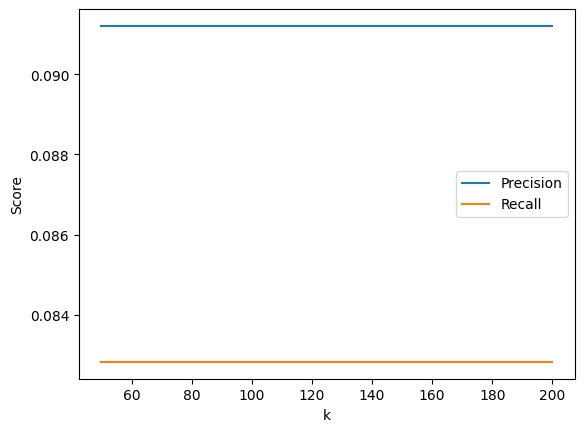

In [85]:
import matplotlib.pyplot as plt

# Define a list of possible values of k
k_values = [50, 100, 150, 200]

# Initialize empty lists to store the precision and recall scores for each value of k
precisions = []
recalls = []

# Evaluate the model for each value of k and append the scores to the lists
for k in k_values:
    precision, recall = evaluate_model(model, test_paper_ids[:100], embedding_map, reference_map, knn_k=k)
    precisions.append(precision)
    recalls.append(recall)

# Plot the precision and recall curves as a function of k
plt.plot(k_values, precisions, label="Precision")
plt.plot(k_values, recalls, label="Recall")
plt.xlabel("k")
plt.ylabel("Score")
plt.legend()
plt.show()


#### Defining the loss function

In [109]:
class PairwiseRankingLoss(nn.Module):
    def __init__(self, margin):
        super(PairwiseRankingLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        distance_positive = (anchor - positive).pow(2).sum(1)
        distance_negative = (anchor - negative).pow(2).sum(1)
        loss = torch.relu(distance_positive - distance_negative + self.margin)
        return loss.mean()

In [127]:
def pad_collate(batch):
    # get the max sequence length
    max_size = max([len(b[1]) for b in batch])
    # pad the sequences
    padded_batch = []
    for b in batch:
        padded_paper_embedding = torch.tensor(b[0])
        padded_reference_embeddings = pad_sequence(b[1], batch_first=True, padding_value=0)
        padded_batch.append((padded_paper_embedding, padded_reference_embeddings))
    return padded_batch


In [154]:
dataset = PaperDataset(embedding_map, reference_map)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)#, collate_fn=pad_collate)

In [117]:
input_size = 768
hidden_size = 256
margin = 1.0

In [158]:
model = FineTuningModel(input_size, hidden_size)
model.to(DEVICE)
loss_function = PairwiseRankingLoss(margin)
optimizer = optim.Adam(model.parameters(), lr=0.001)

#### Training

In [159]:
num_epochs = 10

for epoch in range(num_epochs):
    for batch in dataloader:
        paper_embedding, reference_embeddings = batch
        # paper_embedding.to(DEVICE)
        # reference_embeddings.to(DEVICE)
        paper_embedding = torch.tensor(paper_embedding).to(DEVICE)
        reference_embeddings = torch.tensor(reference_embeddings).to(DEVICE)

        optimizer.zero_grad()

        # Generate negative samples
        negative_indices = np.random.choice(len(dataset), len(reference_embeddings))
        negative_embeddings = torch.stack([dataset[i][0] for i in negative_indices])
        negative_embeddings = negative_embeddings.to(DEVICE)

        anchor_output = model(paper_embedding)
        positive_outputs = model(reference_embeddings)
        negative_outputs = model(negative_embeddings)

        loss = loss_function(anchor_output, positive_outputs, negative_outputs)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}")
    break

/tmp/ipykernel_62/3324542483.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(paper_embedding, dtype=torch.float32), torch.stack(reference_embeddings)
/tmp/ipykernel_62/289649723.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  paper_embedding = torch.tensor(paper_embedding).to(DEVICE)
/tmp/ipykernel_62/289649723.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reference_embeddings = torch.tensor(reference_embeddings).to(DEVICE)


Epoch 1/10, Loss: 1.0000286102294922


#### Evaluation with Precision @ 20 and Recall @ 20

In [162]:
DEVICE

'cuda'

In [164]:
def evaluate_model(model, test_dataloader):
    model.eval()
    model.to(DEVICE)
    with torch.no_grad():
        precision_scores = []
        recall_scores = []

        for batch in test_dataloader:
            paper_embedding, reference_embeddings = batch
            paper_embedding.to(DEVICE)
            reference_embeddings.to(DEVICE)
            anchor_output = model(paper_embedding)
            reference_outputs = model(reference_embeddings)

            _, top_k_indices = reference_outputs.topk(20, dim=1)
            top_k_references = reference_embeddings[top_k_indices]
            top_k_references.to(DEVICE)

            true_positive = (top_k_references == reference_embeddings).sum().item()
            precision = true_positive / 20
            recall = true_positive / len(reference_embeddings)

            precision_scores.append(precision)
            recall_scores.append(recall)

        mean_precision = np.mean(precision_scores)
        mean_recall = np.mean(recall_scores)

    return mean_precision, mean_recall

precision, recall = evaluate_model(model, dataloader)
print(f"Precision@20: {precision:.4f}")
print(f"Recall@20: {recall:.4f}")


/tmp/ipykernel_62/3324542483.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(paper_embedding, dtype=torch.float32), torch.stack(reference_embeddings)


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_addmm)

In [25]:
class RankNet(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RankNet, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x1, x2):
        x = torch.cat((x1, x2), dim=0)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [26]:
def pairwise_ranking_loss(scores, labels, margin=1.0):
    diff = labels * (margin - scores)
    loss = torch.nn.functional.relu(diff)
    return loss.mean()

In [27]:
num_recommendations = 100
K = 10

X = []
y = []

# TODO: optimize with multiprocessing with 8 processes and balance -1s with 1s (say 10 of each per paper)

for i, cur_paper_id in enumerate(all_paper_ids):
    cur_references = reference_map[cur_paper_id]
    cur_paper = metadata[cur_paper_id]
    cur_paper_emb = get_embedding(cur_paper, embedding_map = embedding_map)
    top_indices, top_values = find_similar_knn(cur_paper_emb, weights, k=num_recommendations, least=False)
    cur_recommendations = [all_paper_ids[i] for i in top_indices]

    # TODO remove this line 
    cur_recommendations.remove(cur_paper_id)
    
    # p,r,f1 = evaluate(cur_recommendations, cur_references, k=K)
    # print(f'{cur_paper_id=}{p=}{r=}{f1=}')
    
    for rec in cur_recommendations:
        X.append((cur_paper_id, rec))
        y.append(1 if rec in cur_references else -1)
        
    if i % 500 == 0: 
        print(f'{i} paper IDs processed')

0 paper IDs processed
500 paper IDs processed
1000 paper IDs processed


KeyboardInterrupt: 

In [28]:
def data_sanity_check(X=None, y = None, sample_size = 20):
    assert(X is not None and y is not None)
    # randomly sample 5 items from both X and y
    indices = random.sample(range(len(X)), sample_size)
    X_sample = [X[i] for i in indices]
    y_sample = [y[i] for i in indices]

    # print the sampled X and y
    # print(X_sample)  # output: [4, 8, 2, 9, 1]
    # print(y_sample)  # output: ['d', 'i', 'b', 'j', 'a']

    for (q,r), label in zip(X_sample, y_sample):
        q_refs = reference_map[q]
        
        if (label == 1 and r not in q_refs) or (label == -1 and r in q_refs):
            print('There\'s been a problem')
            return
            
    print('Saul Goodman')

In [29]:
data_sanity_check(X, y, sample_size = 10000)

Saul Goodman


In [30]:
len(X), len(y)

(131571, 131571)

In [31]:
embedding_dim = 768
input_size = embedding_dim * 2
hidden_size = 256
output_size = 1
model = RankNet(input_size, hidden_size, output_size).to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
loss = torch.nn.MarginRankingLoss(margin = 1)

In [32]:
torch.tensor([y[i]])

tensor([-1])

In [33]:
label

NameError: name 'label' is not defined

In [78]:
loss(score1, score2, label).item()

0.0

In [35]:
type(output.item())

torch.Tensor

In [52]:
for epoch in range(1):
    for i, (cur_id, rec_id) in enumerate(X):
        x1 = torch.tensor(embedding_map[cur_id], dtype=torch.float32, requires_grad=True).to(DEVICE)
        x2 = torch.tensor(embedding_map[rec_id], dtype=torch.float32, requires_grad=True).to(DEVICE)
        label = torch.tensor([y[i]], dtype=torch.float32, requires_grad=True).to(DEVICE)
        score1 = model(x1, x2)
        score2 = model(x2, x1)
        # loss = pairwise_ranking_loss(score1 - score2, y[i])
        # x1o, x2o = out.chunk(2)
        output = loss(score1, score2, label)
        optimizer.zero_grad()
        output.backward()
        optimizer.step()
        
        if i % 10000 == 0:
            
            print(output.item())
        
        
    print(f'{epoch=}: {loss=}')

epoch=0: loss=MarginRankingLoss()


In [37]:
torch.tensor(embedding_map[rec_id]).shape

torch.Size([768])

In [56]:
x1.view(-1).shape

torch.Size([768])

In [57]:
# new_paper = {'title': new_title, 'abstract': new_abstract or ''}
# assert new_paper['title'] is not None
# paper_id = '204e3073870fae3d05bcbc2f6a8e263d9b72e776'
k = 10
paper_id = '204e3073870fae3d05bcbc2f6a8e263d9b72e776'
paper_embedding = get_embedding(metadata[paper_id])
top_indices, top_values = find_similar_knn(paper_embedding, weights, k=10, least=False)
recommended_paper_ids = [all_paper_ids[i] for i in top_indices]

model.eval()
with torch.no_grad():
    scores = []
    x1 = paper_embedding.view(-1).float().to(DEVICE)
    
    for idx, rec_id in enumerate(recommended_paper_ids):
        # (768,) -> (1, 768)
        x2 = torch.tensor(embedding_map[rec_id]).float().to(DEVICE)
        # print(x1.shape)
        score = model(x1, x2).item()
        print(score)
        scores.append((score, idx))
        idx += 1
        
    scores.sort(reverse=True)
    updated_rec_ids = [(recommended_paper_ids[j], score) for score, j in scores]
    
model.train() 

-0.00023286789655685425
-0.00023286789655685425
-0.00023286789655685425
-0.00023286789655685425
-0.00023286789655685425
-0.00023286789655685425
-0.00023286789655685425
-0.00023286789655685425
-0.00023286789655685425
-0.00023286789655685425


RankNet(
  (fc1): Linear(in_features=1536, out_features=256, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=256, out_features=1, bias=True)
)

In [58]:
scores

[(-0.00023286789655685425, 9),
 (-0.00023286789655685425, 8),
 (-0.00023286789655685425, 7),
 (-0.00023286789655685425, 6),
 (-0.00023286789655685425, 5),
 (-0.00023286789655685425, 4),
 (-0.00023286789655685425, 3),
 (-0.00023286789655685425, 2),
 (-0.00023286789655685425, 1),
 (-0.00023286789655685425, 0)]

In [59]:
updated_rec_ids

[('bf8fe437f779f2098f9af82b534aa51dc9edb06f', -0.00023286789655685425),
 ('25eb839f39507fe6983ad3e692b2f8d93a5cb0cc', -0.00023286789655685425),
 ('bb669de2fce407df2f5cb2f8c51dedee3f467e04', -0.00023286789655685425),
 ('4550a4c714920ef57d19878e31c9ebae37b049b2', -0.00023286789655685425),
 ('93499a7c7f699b6630a86fad964536f9423bb6d0', -0.00023286789655685425),
 ('43428880d75b3a14257c3ee9bda054e61eb869c0', -0.00023286789655685425),
 ('dbde7dfa6cae81df8ac19ef500c42db96c3d1edd', -0.00023286789655685425),
 ('9ae0a24f0928cab1554a6ac880f6b350f85be698', -0.00023286789655685425),
 ('b60abe57bc195616063be10638c6437358c81d1e', -0.00023286789655685425),
 ('204e3073870fae3d05bcbc2f6a8e263d9b72e776', -0.00023286789655685425)]

In [60]:
cnt = 0
for paper_id, upd_sim in updated_rec_ids:
    title = metadata[paper_id]['title']
    # abstract = metadata[paper_id]['abstract']
    year = metadata[paper_id]['year']
    print(f'Paper ID: {paper_id}\nTitle: {title}\nYear: {year}\n Updated similarity: {upd_sim}\n')
    cnt += 1 
    if cnt == 10:
        break
        
actual_references = ast.literal_eval(metadata['204e3073870fae3d05bcbc2f6a8e263d9b72e776'].get('references'))

print('-'*100)

precision, recall, f1_score = evaluate(updated_rec_ids, actual_references, k=k)
print(f"Precision @ {k}: {precision}")
print(f"Recall @ {k}: {recall}")
print(f"F1 Score: {f1_score}")

Paper ID: bf8fe437f779f2098f9af82b534aa51dc9edb06f
Title: Scaling Neural Machine Translation
Year: 2018
 Updated similarity: -0.00023286789655685425

Paper ID: 25eb839f39507fe6983ad3e692b2f8d93a5cb0cc
Title: Montreal Neural Machine Translation Systems for WMT’15
Year: 2015
 Updated similarity: -0.00023286789655685425

Paper ID: bb669de2fce407df2f5cb2f8c51dedee3f467e04
Title: The Best of Both Worlds: Combining Recent Advances in Neural Machine Translation
Year: 2018
 Updated similarity: -0.00023286789655685425

Paper ID: 4550a4c714920ef57d19878e31c9ebae37b049b2
Title: Massive Exploration of Neural Machine Translation Architectures
Year: 2017
 Updated similarity: -0.00023286789655685425

Paper ID: 93499a7c7f699b6630a86fad964536f9423bb6d0
Title: Effective Approaches to Attention-based Neural Machine Translation
Year: 2015
 Updated similarity: -0.00023286789655685425

Paper ID: 43428880d75b3a14257c3ee9bda054e61eb869c0
Title: Convolutional Sequence to Sequence Learning
Year: 2017
 Updated s